In [1]:
# Numismatic ETL Pipeline
# Theo Forget
# May 29th, 2025
#
# This notebook processes and analyzes a personal numismatic (banknote) collection exported from Numista.
# It parses the 'Private comment' field, integrates live currency exchange rates via API to calculate real-time USD valuations,
# detects errors (e.g., malformed entries, unknown currency codes), and visualizes key insights such as top-value items and acquirer statistics.
# Technologies used: Python, Pandas, Requests, Matplotlib.

# Install and Import Dependencies
!pip install pandas numpy requests beautifulsoup4 matplotlib

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [2]:
# Load the CSV File
csv_path = "/Users/theoforget/Downloads/theoforget_export.csv"
df = pd.read_csv(csv_path)

In [3]:
# Define Parsing Function and Apply It

def parse_private_comment(comment):
    try:
        cleaned = comment.replace("\u202f", " ").strip()
        parts = [part.strip() for part in cleaned.split(",")]
        return pd.Series(parts) if len(parts) == 7 else pd.Series([None]*7)
    except Exception:
        return pd.Series([None]*7)

# Apply parsing to 'Private comment'
parsed_cols = df['Private comment'].apply(parse_private_comment)
parsed_cols.columns = [
    "Parsed_Grade", "Parsed_SerialNumber", "Parsed_LocationAcquired",
    "Parsed_DateAcquired", "Parsed_Acquirer", "Parsed_Denomination", "Parsed_CountryCode"
]

# Merge parsed data with original dataframe
df_clean = pd.concat([df, parsed_cols], axis=1)
df_clean['Parsed_Denomination'] = pd.to_numeric(df_clean['Parsed_Denomination'], errors='coerce')
df_clean['Parsed_CountryCode'] = df_clean['Parsed_CountryCode'].str.upper()

In [4]:
# Identify Malformed Rows
malformed_rows = df_clean[df_clean[['Parsed_Grade', 'Parsed_SerialNumber', 'Parsed_LocationAcquired', 
                                    'Parsed_DateAcquired', 'Parsed_Acquirer', 
                                    'Parsed_Denomination', 'Parsed_CountryCode']].isnull().any(axis=1)]
print(f"Number of malformed rows: {len(malformed_rows)}")
print(malformed_rows[['Title', 'Private comment']].head())

Number of malformed rows: 38
                      Title                                    Private comment
16                   10 Lek  Ungraded, U437795, North Macedonia, 2024, Theo...
17             5 Franka Ari  Ungraded, X38152, North Macedonia, 2024, Theo ...
18                 100 Leke  Ungraded, AB629828, North Macedonia, 2024, The...
21                 500 Lekë  Ungraded, HR548854, Albania, ?, Stephan Forget...
108  20 Francs - Baudouin I  Ungraded,  1E6888029, Belgique, ?, Jean-Paul C...


In [5]:
# Fetch Exchange Rates via API

api_key = "68451529dc62af68211f1843"
url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/USD"
response = requests.get(url)

if response.status_code == 200:
    rates_dict = response.json()['conversion_rates']
    print("Exchange rates fetched successfully.")
else:
    rates_dict = {}
    print("Error fetching exchange rates.")

# Identify country codes from the data that aren't recognized by the API
all_codes = df_clean['Parsed_CountryCode'].dropna().unique()
unrecognized_codes = [code for code in all_codes if code not in rates_dict]
print(f"Unrecognized country codes: {unrecognized_codes}")

Exchange rates fetched successfully.
Unrecognized country codes: ['AFA', 'LTL', 'SIT', 'SLS', 'PRB']


In [6]:
# Define USD Conversion Function and Apply It

# Convert each banknote's denomination into USD
def calculate_usd_value(row):
    denom = row['Parsed_Denomination']
    code = row['Parsed_CountryCode']
    if pd.isna(denom) or pd.isna(code):
        return None
    rate = rates_dict.get(code)
    return denom / rate if rate else None

df_clean['Live_USD_Value'] = df_clean.apply(calculate_usd_value, axis=1)

In [7]:
# Error Detection and Export to CSV

# Identify rows with missing data or unknown currencies for review
df_clean['Parsing_Error'] = df_clean[['Parsed_Grade', 'Parsed_SerialNumber', 'Parsed_LocationAcquired', 
                                      'Parsed_DateAcquired', 'Parsed_Acquirer', 'Parsed_Denomination', 'Parsed_CountryCode']].isnull().any(axis=1)
df_clean['Unknown_Currency'] = ~df_clean['Parsed_CountryCode'].isin(rates_dict.keys()) & df_clean['Parsed_CountryCode'].notna()

error_rows = df_clean[df_clean['Parsing_Error'] | df_clean['Unknown_Currency']]
error_csv_path = "/Users/theoforget/Downloads/error_entries.csv"
error_rows.to_csv(error_csv_path, index=False)
print(f"Exported {len(error_rows)} error entries to {error_csv_path}")

Exported 71 error entries to /Users/theoforget/Downloads/error_entries.csv


In [8]:
# Summary Statistics and Estimated Value

total_value = df_clean['Live_USD_Value'].sum()
total_rows = len(df_clean)
converted_rows = df_clean['Live_USD_Value'].notna().sum()
# Estimate total collection value even for notes with missing data by scaling up
estimated_value = total_value * (total_rows / converted_rows) if converted_rows else 0

print(f"Total collection value (exact): ${total_value:,.2f}")
print(f"Estimated total value: ${estimated_value:,.2f}")
print(f"Total items: {total_rows}, Items with live value: {converted_rows}, Missing values: {total_rows - converted_rows}")

Total collection value (exact): $2,987.74
Estimated total value: $3,210.57
Total items: 1023, Items with live value: 952, Missing values: 71


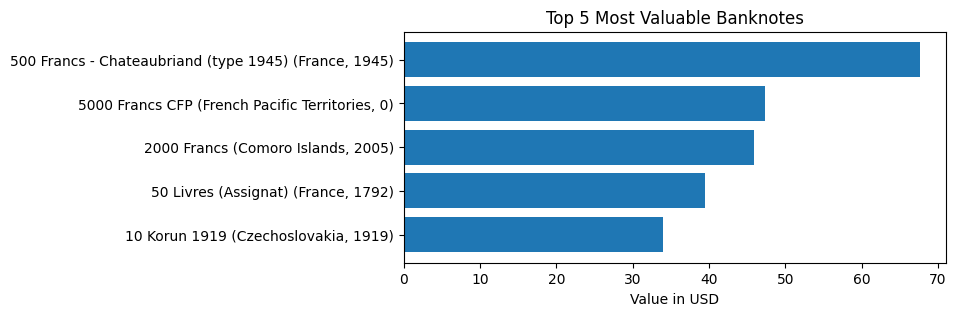

In [9]:
# Visualization: Top 5 Most Valuable Banknotes

df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce').fillna(0).astype(int)
top_notes = df_clean.sort_values(by='Live_USD_Value', ascending=False).head(5)
top_notes['Label'] = top_notes['Title'] + " (" + top_notes['Issuer'] + ", " + top_notes['Year'].astype(str) + ")"

plt.figure(figsize=(7, 3))
plt.barh(top_notes['Label'], top_notes['Live_USD_Value'])
plt.xlabel('Value in USD')
plt.title('Top 5 Most Valuable Banknotes')
plt.gca().invert_yaxis()
plt.show()

In [10]:
# Acquirer Counts

acquirer_counts = df_clean['Parsed_Acquirer'].value_counts(dropna=True)
print("\nAcquirers and the number of banknotes they acquired:")
print(acquirer_counts.to_string(index=True, header=False))


Acquirers and the number of banknotes they acquired:
Stephan Forget            673
Theo Forget               285
Florence Cohen Solal        7
Jean-Paul Cohen Solal       5
Julie Forget                5
Aswani Aswaid               4
Beatriz Aguiar Fonseca      2
Regine Solal                1
Duncan Koblas               1
Tatabelle/Mamita            1
Traile Wilson               1


In [11]:
# Consistency Check (Location vs Issuer)

# Check if the acquisition location matches the issuer or is a substring
condition_equal = df_clean['Parsed_LocationAcquired'] == df_clean['Issuer']
condition_substring = df_clean.apply(
    lambda row: pd.notna(row['Parsed_LocationAcquired']) and pd.notna(row['Issuer']) and 
                row['Parsed_LocationAcquired'] in row['Issuer'],
    axis=1
)
matching_rows = df_clean[condition_equal | condition_substring]
print(f"\nLocation matches Issuer: {len(matching_rows)} items")
print(f"Location does NOT match Issuer: {len(df_clean) - len(matching_rows)} items")


Location matches Issuer: 868 items
Location does NOT match Issuer: 155 items
